In [1]:
import numpy
import math

import random
import time
import matplotlib.pyplot as plt

In [2]:
environment = numpy.zeros((7, 7))
trans_prob = 1
environment[6, 6] = 10
#environment[8, 8] = -10
#environment[2, 3] = -5

In [3]:
alpha = 0.1
gamma = 0.9

In [4]:
def get_legal_actions(pos):
    legal_actions = list()
    new_pos = list()
    all_actions = [[1, 0], [0, 1], [-1, 0], [0, -1]]
    for i in all_actions:
        try:
            new_pos = numpy.add(pos, numpy.array(i))
            legal_actions.append(i)
            env = environment[new_pos[0]][new_pos[1]]
            if any(j < 0 for j in new_pos):
                legal_actions.pop()
        except IndexError:
            legal_actions.pop()
            
        
    return legal_actions

In [5]:
def take_action(pos, action):
    # Take action in the actual environment and return a reward and new position based on environment dynamics
    if numpy.random.rand(1) < trans_prob:
        new_pos = numpy.add(pos, action)
    else:
        new_pos = numpy.add(pos, random.choice(get_legal_actions(pos)))
    reward = environment[new_pos[0]][new_pos[1]]
    return new_pos, reward

In [6]:
mb_internal_environment = numpy.zeros((7, 7))
mb_internal_environment[6, 6] = 10
print mb_internal_environment

[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  10.]]


In [7]:
def mb_internal_environment_value(pos, mb_internal_environment):
    value = mb_internal_environment[pos[0], pos[1]]
    return value

In [8]:
def update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment):
    next_value_list = list()
    for i in get_legal_actions(next_pos):
        next_value_list.append(mb_internal_environment[next_pos[0]][next_pos[1]])
    next_value = max(next_value_list)
    mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward + gamma*next_value)
    return mb_internal_environment


In [9]:
def dls(pos, curr_depth, max_depth, mb_internal_environment):
    value_list = list()
    if curr_depth == max_depth:
        return mb_internal_environment_value(pos, mb_internal_environment)
    else:
        actions = get_legal_actions(pos)
        for i in actions:
            next_pos = numpy.add(numpy.array(pos), numpy.array(i))
            value = mb_internal_environment_value(pos, mb_internal_environment) + gamma * dls(next_pos, curr_depth+1, max_depth, mb_internal_environment)
            value_list.append(value)
        if value_list:
            average_value = numpy.mean(numpy.array(value_list))
    return average_value

In [10]:
def dls_action(pos, max_depth, mb_internal_environment):
    # Do depth Limited Search till max_depth on the mb_internal_environment
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(dls(next_pos, 0, max_depth, mb_internal_environment))
        next_pos_list.append(next_pos)
    zipped = list(zip(actions, next_value_list))
    random.shuffle(zipped)
    actions, next_value_list = zip(*zipped)
    random.shuffle(zip(actions, next_value_list))
    action = actions[numpy.argmax(next_value_list)]
    return action

In [11]:
def q_action(pos, mb_internal_environment):
    # Look for q values in mf_internal_environment for given position
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(mb_internal_environment[next_pos[0], next_pos[1]])
        next_pos_list.append(next_pos)
    random.shuffle(actions)
    action = actions[numpy.argmax(next_value_list)]
    return action

In [12]:
def dual(num_iters, mb_internal_environment):
    sum_reward = 0
    max_depth = 4
    steps_per_reward = 0
    steps = list()
    time_per_reward = list()
    
    for i in range(num_iters):
        pos = [0, 0]
        j = 0
        goal_start_time = time.time()
        
        while True:
            if j%(i+1) == 0:
                action = dls_action(pos, max_depth, mb_internal_environment)
                next_pos, reward = take_action(pos, action)
                mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
                pos = next_pos
            else:
                action = q_action(pos, mb_internal_environment)
                next_pos, reward = take_action(pos, action)
                mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
                pos = next_pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            j += 1
            if reward != 0:
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)
                steps.append(steps_per_reward)
                steps_per_reward = 0
                #print "here", pos
                goal_time = time.time()
                time_per_reward.append(goal_time - goal_start_time)
                
                break
    return sum_reward, steps, mb_internal_environment, time_per_reward

In [13]:
def mb(num_iters, mb_internal_environment):
    sum_reward = 0
    max_depth = 4
    steps = list()
    time_per_reward = list()
    for i in range(num_iters):
        pos = [0, 0]
        steps_per_reward = 0
        #print (mb_internal_environment)    
        goal_start_time = time.time()
        while True:
            action = dls_action(pos, max_depth, mb_internal_environment)
            next_pos, reward = take_action(pos, action)
            mb_internal_environemnt = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
            pos = next_pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)                
                steps.append(steps_per_reward)
                steps_per_reward = 0
                goal_time = time.time()
                time_per_reward.append(goal_time - goal_start_time)
                #print "here"
                break

    return sum_reward, steps, mb_internal_environment, time_per_reward

In [14]:
def mf(num_iters, mb_internal_environment):
    sum_reward = 0
    steps = list()
    time_per_reward = list()
    
    for i in range(num_iters):
        pos = [0, 0]
        steps_per_reward = 0        
        #print (mb_internal_environment)
        goal_start_time = time.time()
        
        while True:
            action = q_action(pos, mb_internal_environment)
            next_pos, reward = take_action(pos, action)
            mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
            pos = next_pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)
                steps.append(steps_per_reward)
                steps_per_reward = 0
                goal_time = time.time()
                time_per_reward.append(goal_time - goal_start_time)
                
                break
            
    return sum_reward, steps, mb_internal_environment, mb_internal_environment, time_per_reward

In [15]:
mb_internal_environment = numpy.zeros((7, 7))
mb_internal_environment[6, 6] = 10
print mb_internal_environment

[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  10.]]


Run the Dual Process on grid world. Get a list of individual time taken for each and rewards obtained.

In [16]:
times_dual = list()
reward_dual = list()
steps_dual = list()
time_per_reward_dual = list()
for i in range(5):
    mb_internal_environment = numpy.zeros((7, 7))
    mb_internal_environment[6, 6] = 10
    start_time = time.time()
    dual_result = dual(40, mb_internal_environment)
    reward_dual.append(dual_result[0])
    steps_dual.append(dual_result[1])
    times_dual.append(time.time() - start_time)
    time_per_reward_dual.append(dual_result[3])

In [17]:
times_mb = list()
reward_mb = list()
steps_mb = list()
time_per_reward_mb = list()
for i in range(5):
    mb_internal_environment = numpy.zeros((7, 7))
    mb_internal_environment[6, 6] = 10
    start_time = time.time()
    mb_result = mb(40, mb_internal_environment)
    reward_mb.append(mb_result[0])
    steps_mb.append(mb_result[1])
    times_mb.append(time.time() - start_time)
    time_per_reward_mb.append(mb_result[3])


In [18]:
times_mf = list()
reward_mf = list()
steps_mf = list()
time_per_reward_mf = list()
for i in range(5):
    mb_internal_environment = numpy.zeros((7, 7))
    mb_internal_environment[6, 6] = 10
    start_time = time.time()
    mf_result = mf(40, mb_internal_environment)
    reward_mf.append(mf_result[0])
    steps_mf.append(mf_result[1])
    times_mf.append(time.time() - start_time)
    time_per_reward_mf.append(mf_result[4])

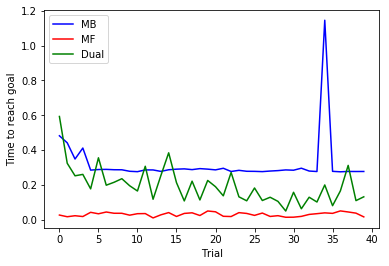

In [19]:
#print (sum(steps_mf)/300)
#print (sum(steps_mb)/300)

#print (sum(steps_dual)/300)
#print (numpy.mean(numpy.array(steps_mf), axis=0))
#print (numpy.mean(numpy.array(steps_dual), axis=0))
#print (numpy.mean(numpy.array(steps_mb), axis=0))

#stepsmf_plot, = plt.plot(numpy.arange(0, 35), numpy.mean(numpy.array(steps_mf), axis=0), color = 'r')
#stepsdual_plot, = plt.plot(numpy.arange(0, 35), numpy.mean(numpy.array(steps_dual), axis=0), color = 'g')
#stepsmb_plot, = plt.plot(numpy.arange(0, 35), numpy.mean(numpy.array(steps_mb), axis=0), color = 'b')

timeperrewardmb_plot = plt.plot(numpy.arange(0, 40), numpy.mean(numpy.array(time_per_reward_mb), axis=0), color = 'b', label = 'MB')
timeperrewardmf_plot = plt.plot(numpy.arange(0, 40), numpy.mean(numpy.array(time_per_reward_mf), axis=0), color = 'r', label = 'MF')
timeperrewarddual_plot = plt.plot(numpy.arange(0, 40), numpy.mean(numpy.array(time_per_reward_dual), axis=0), color = 'g', label = 'Dual')
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Time to reach goal')

#plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.show()

In [20]:
reward_mean_dual = numpy.mean(numpy.array(reward_dual))
reward_mean_mb = numpy.mean(numpy.array(reward_mb))
reward_mean_mf = numpy.mean(numpy.array(reward_mf))
times_mean_dual = numpy.mean(numpy.array(times_dual))
times_mean_mb = numpy.mean(numpy.array(times_mb))
times_mean_mf = numpy.mean(numpy.array(times_mf))
steps_mean_dual = sum(steps_dual[0])
steps_mean_mb = sum(steps_mb[0])
steps_mean_mf = sum(steps_mf[0])


In [21]:
print steps_mf

[[156, 246, 274, 138, 230, 192, 502, 130, 458, 162, 76, 292, 118, 144, 344, 90, 110, 532, 178, 102, 176, 52, 80, 766, 160, 274, 154, 80, 36, 104, 32, 42, 42, 140, 434, 236, 714, 252, 98, 62], [270, 62, 138, 86, 336, 570, 232, 100, 150, 84, 336, 68, 38, 246, 40, 150, 38, 292, 54, 286, 282, 200, 48, 42, 178, 88, 68, 234, 252, 90, 150, 62, 330, 220, 70, 660, 562, 40, 600, 124], [144, 132, 162, 154, 332, 86, 96, 146, 178, 90, 66, 102, 42, 352, 422, 102, 664, 22, 330, 440, 30, 80, 92, 208, 422, 60, 22, 64, 280, 44, 50, 66, 118, 200, 440, 42, 94, 384, 86, 132], [32, 46, 96, 90, 94, 136, 120, 694, 274, 418, 254, 170, 68, 82, 380, 120, 150, 414, 22, 238, 494, 192, 310, 210, 210, 244, 348, 148, 78, 172, 190, 170, 74, 484, 30, 38, 112, 368, 292, 96], [242, 52, 52, 114, 400, 120, 482, 62, 74, 48, 316, 528, 52, 72, 78, 124, 220, 20, 170, 482, 494, 94, 40, 90, 202, 138, 668, 80, 96, 30, 30, 256, 384, 82, 290, 182, 146, 178, 118, 102]]


In [22]:
3%5

3

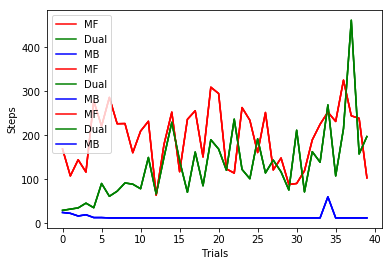

In [30]:
stepsmf_plot, = plt.plot(numpy.arange(0, 40), numpy.mean(numpy.array(steps_mf), axis=0), color = 'r', label = 'MF')
stepsdual_plot, = plt.plot(numpy.arange(0, 40), numpy.mean(numpy.array(steps_dual), axis=0), color = 'g', label = 'Dual')
stepsmb_plot, = plt.plot(numpy.arange(0, 40), numpy.mean(numpy.array(steps_mb), axis=0), color = 'b', label = 'MB')
plt.legend()
plt.xlabel("Trials")
plt.ylabel("Steps")
plt.show()

In [23]:
rewards = numpy.array([reward_mean_mb, reward_mean_dual, reward_mean_mf])
#yerror = numpy.array(reward_errors)
print (rewards)

[ 5.001221  5.        5.      ]


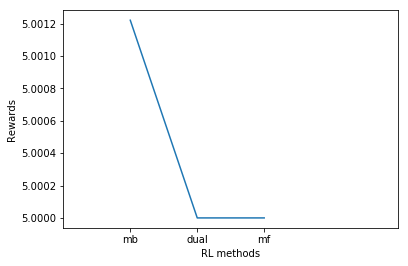

In [24]:
reward_plot, = plt.plot(numpy.arange(0, 3), rewards)
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
#plt.ylim(ymin = 4.5, ymax = 5.5)
plt.xlabel('RL methods')
plt.ylabel("Rewards")

plt.show()

[ 12.72956142   7.75155082   1.19149981]


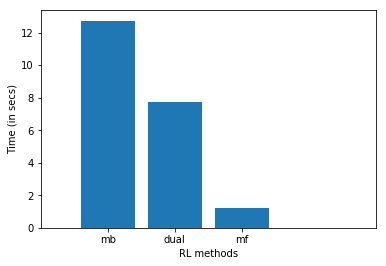

In [25]:
times = numpy.array([times_mean_mb, times_mean_dual, times_mean_mf])
print (times)
plt.bar(numpy.arange(3), times, align='center')
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
#plt.ylim(ymin = -1, ymax = 10)
plt.xlabel('RL methods')
plt.ylabel("Time (in secs)")

plt.show()

[ 562 4364 8408]


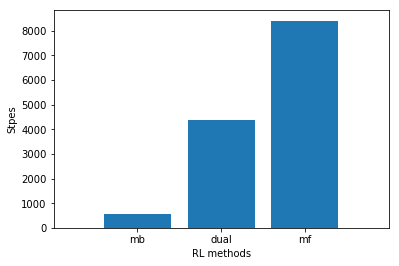

In [26]:
steps = numpy.array([steps_mean_mb, steps_mean_dual, steps_mean_mf])
print (steps)
plt.bar(numpy.arange(3), steps, align='center')
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 3)
#plt.ylim(ymin = 350, ymax = 400)
plt.xlabel('RL methods')
plt.ylabel("Stpes")

plt.show()